In [1]:
import pandas as pd
import seaborn as sbn
import geopandas as geo_pd
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import sqlite3
import os

# Two Step Floating Catchment Calculation

**Overview**

This notebook provides GeoSpatial analysis of fire incidents in San Francisco, with the goal of identifying candidate locations for a new fire station (should the city choose to build one).
1. It divides the city into square regions (called "zones"). 
2. It estimates the area that each fire station (where trucks and engines are based) can respond to within 5 minutes with a high degree of certainty using Kernel Density Estimation.  
3. It estimate the frequency of events requiring a Fire Unit (truck or engine) to respond for 2019 for each zone. 
4. It combines #2 and #3 to develop a measure of **spatial accessiblity** using the Two-Step Floating Catchment Algorithm (2SFCA), which is the coverage (or number of units) available to response within 5 minutes at each location.
5. It simulates placement of a new (hypothetical) fire station in about 300 different equidistant locations.

## Load Data

In [2]:
# setup the relative paths that this analysis uses to load and output data
data_dir_prefix = '../data/'
vis_dir_prefix = '../visualization/'
database_path = data_dir_prefix + 'fire_data_v4.db'

Gather **incident response data** for 2019 and the **locations of existing fire stations**.  
* We use 2019 data because it was pre-COVID and expected to be a more normal year for traffic and response times.  Since we are using GeoPandas

In [3]:
# query the unit response data for 2019
with sqlite3.connect(database_path) as db_conn:
    # get unit response data
    q = """
        SELECT 
            call_number, incident_number, call_type, call_type_group, 
            unit_id, unit_type, 
            call_date, received_dttm, dispatch_dttm, on_scene_dttm,
            `neighborhooods_-_analysis_boundaries`, case_location
        FROM calls_for_service 
        WHERE cast(strftime('%Y', received_dttm) as int) = 2019 
            AND unit_sequence_in_call_dispatch <= 5"""
    unit_response_data_raw = pd.read_sql_query(q, db_conn)

    # get facility data
    fire_station_data_raw = pd.read_sql_query("select * from fire_stations", db_conn)

# convert dataframe to geodataframe (geospatially aware pandas dataframe)
unit_response_data = geo_pd.GeoDataFrame(unit_response_data_raw)
unit_response_data['pt_case_location'] = geo_pd.GeoSeries.from_wkt(
    unit_response_data_raw['case_location'],
    crs='EPSG:4326')

unit_response_data = geo_pd.GeoDataFrame(unit_response_data, 
    geometry='pt_case_location')

unit_response_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 305923 entries, 0 to 305922
Data columns (total 13 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   call_number                           305923 non-null  int64   
 1   incident_number                       305923 non-null  int64   
 2   call_type                             305923 non-null  object  
 3   call_type_group                       304040 non-null  object  
 4   unit_id                               305923 non-null  object  
 5   unit_type                             305923 non-null  object  
 6   call_date                             305923 non-null  object  
 7   received_dttm                         305923 non-null  object  
 8   dispatch_dttm                         305923 non-null  object  
 9   on_scene_dttm                         254063 non-null  object  
 10  neighborhooods_-_analysis_boundaries  305923 non

In [4]:
# using the SQL data, construct a second geo dataframe of fire station locations
fire_stations = fire_station_data_raw.copy()
fire_stations['point'] = geo_pd.points_from_xy(fire_station_data_raw.longitude, fire_station_data_raw.latitude, crs="EPSG:4326")
fire_stations = geo_pd.GeoDataFrame(fire_stations, geometry='point')
fire_stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
fire_stations.to_file(vis_dir_prefix+"/data/current_fire_stations.geojson", driver="GeoJSON")

plot locations of existing fire stations on the San Francisco city map

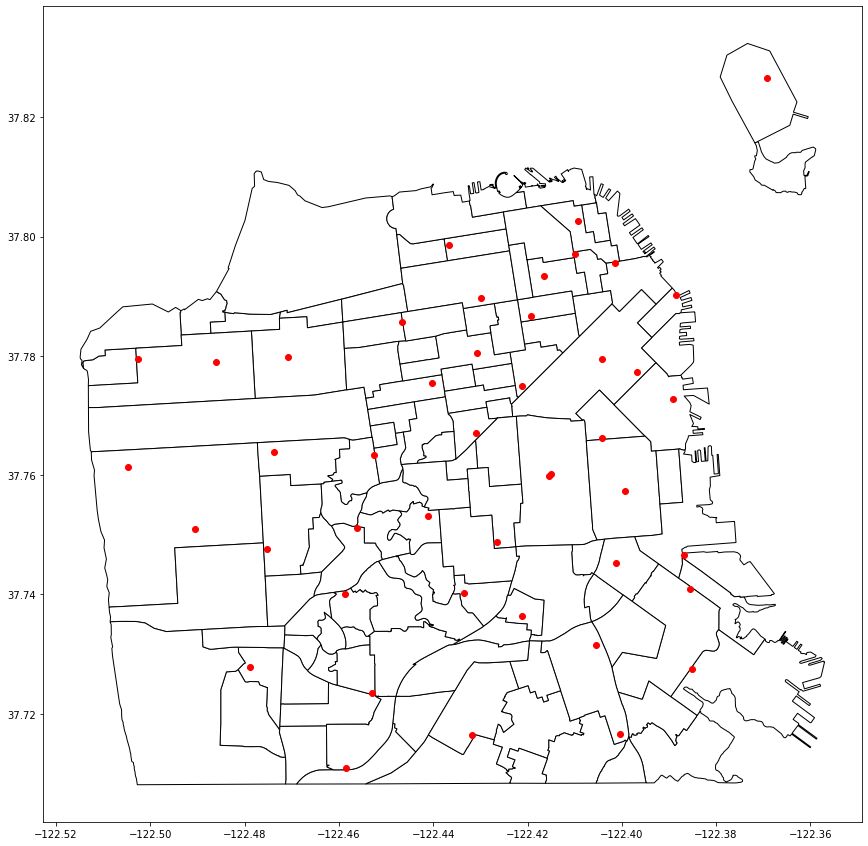

In [8]:
plt.rcParams["figure.figsize"]=15,15

sf_neighborhoods = geo_pd.read_file(data_dir_prefix+'raw/SF Find Neighborhoods.geojson')
base_map = sf_neighborhoods.geometry.plot(edgecolor="black", color="white")

_ = fire_stations.plot(color="red", ax=base_map)

### #1 Create Zones

Divide the city into a grid where we can aggregate the number of incidents (i.e. the frequency of incidents in different parts of the city).  Each grid square represents about 1/3rd of a mile, or about 6 city blocks (6x6 blocks).  

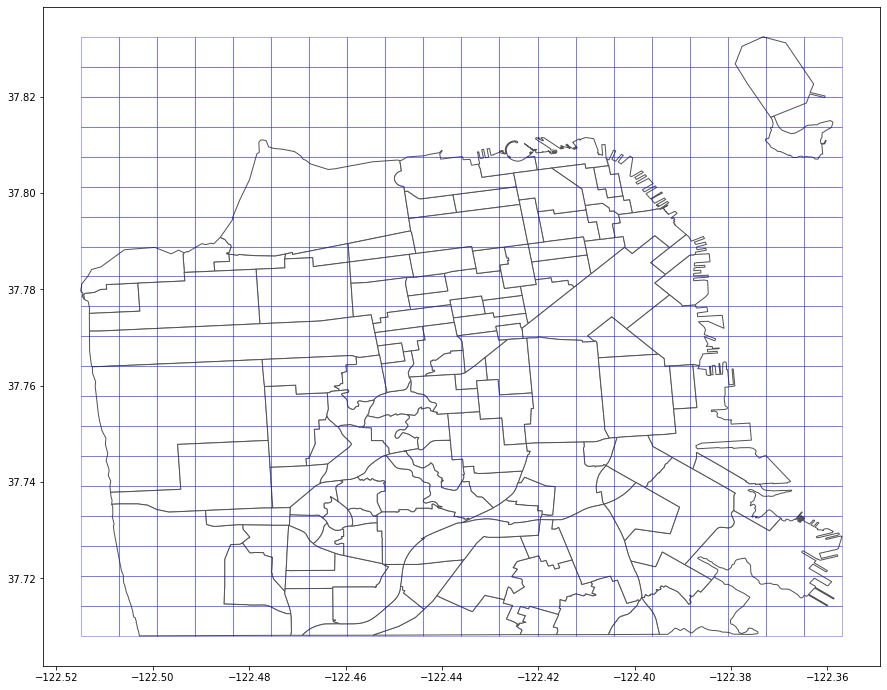

In [9]:
# create quadrat grid
from shapely.geometry import Polygon

# get dimensions of current region
xmin, ymin, xmax, ymax = sf_neighborhoods.geometry.total_bounds
step_size = 20
step_x = (xmax - xmin) / step_size
step_y = (ymax - ymin) / step_size

# create a single column of x and y, to later cross product
x_left = np.arange(xmin, xmax, step_x)
x_df = pd.DataFrame(np.column_stack((x_left,x_left + step_x)), columns=['x_left', 'x_right'])
y_top = np.arange(ymax, ymin, -step_y)
y_df = pd.DataFrame(np.column_stack((y_top, y_top - step_y)), columns=['y_top', 'y_bottom'])

# cross product dummy cols
x_df['dummy'] = 1
y_df['dummy'] = 1

# cross-product to get the grid polygons
grid_polygons = x_df.merge(y_df, on='dummy', how='inner').drop("dummy", axis=1)
grid_polygons

# plot the quadrats
plt.rcParams["figure.figsize"]=15,15
grid_poly = geo_pd.GeoSeries(grid_polygons.apply(lambda d: Polygon([    
    (d.x_left, d.y_top),    
    (d.x_left, d.y_bottom),
    (d.x_right, d.y_bottom),
    (d.x_right, d.y_top)]), axis = 1))

full_plot = sf_neighborhoods.plot(color="white", edgecolor="black")
_ = grid_poly.plot(ax = full_plot, color="white", edgecolor="blue", alpha=0.33)

C:\Users\ande7\anaconda3\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


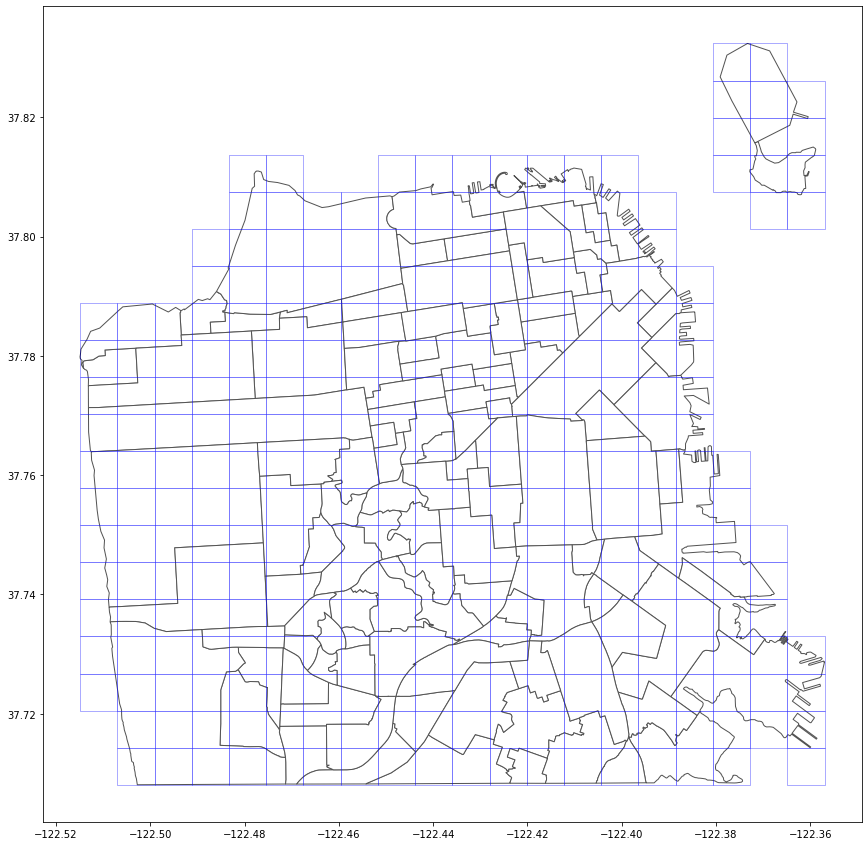

In [10]:
# prune the zones to the ones contained within the city's borders
grid_zones = grid_poly.to_frame("zone").reset_index().rename({"index": "zone_idx"}, axis=1)
grid_zones = geo_pd.GeoDataFrame(grid_zones, crs="EPSG:4326", geometry='zone')
grid_zones = geo_pd.sjoin(grid_zones, sf_neighborhoods, how='inner', op='intersects')[['zone_idx', 'zone']]
grid_zones = grid_zones.drop_duplicates()

full_plot = sf_neighborhoods.plot(color="white", edgecolor="black")
_ = grid_zones.plot(ax = full_plot, color="white", edgecolor="blue", alpha=0.33)

In [11]:
# output the city zones for our later visualization work
grid_zones.to_file(vis_dir_prefix+"/data/grid_definitions.geojson", driver="GeoJSON")
grid_zones.head()

,zone_idx,zone
7,7,"POLYGON ((-122.51490 37.78889, -122.51490 37.7..."
8,8,"POLYGON ((-122.51490 37.78267, -122.51490 37.7..."
27,27,"POLYGON ((-122.50700 37.78889, -122.50700 37.7..."
28,28,"POLYGON ((-122.50700 37.78267, -122.50700 37.7..."
47,47,"POLYGON ((-122.49911 37.78889, -122.49911 37.7..."


### #2 Kernel Density Estimate of <5 min Response Time Region

For each fire unit (truck / engine), estimate the region that it can respond to in under 5 minutes with a high degree of certainty.  Use kernel density estimate to develop this polygon for each unit, and then merge the polygons for each unit assigned to the same station, so that each Fire Station has one polygon indicating the distance its units can respond to in under 5 minutes.

In [12]:
# see if unit responses typically fit into a handful of neighborhoods
pd.set_option('display.max_rows', 30)
unit_response_data['unit_desc'] = unit_response_data.unit_type + ' - ' + unit_response_data.unit_id
unit_response_summary = unit_response_data.groupby(['unit_desc', 'neighborhooods_-_analysis_boundaries'])\
    .agg({'incident_number':'count'}).unstack(fill_value=0.0)

#unit_response_summary.to_csv(data_dir_prefix+'raw/unit_response_summary.csv')
unit_response_summary

incident_number                 \
neighborhooods_-_analysis_boundaries Bayview Hunters Point Bernal Heights   
unit_desc                                                                   
AIRPORT - AP                                           0.0            0.0   
CHIEF - B01                                            3.0            0.0   
CHIEF - B02                                            4.0            3.0   
CHIEF - B03                                           22.0           11.0   
CHIEF - B04                                            0.0            0.0   
...                                                    ...            ...   
TRUCK - T16                                            0.0            0.0   
TRUCK - T17                                          961.0            6.0   
TRUCK - T18                                            1.0            0.0   
TRUCK - T19                                            0.0            0.0   
TRUCK - T48                                            1.0            0.0   

                                                                              \
neighborhooods_-_analysis_boundaries Castro/Upper Market Chinatown Excelsior   
unit_desc                                                                      
AIRPORT - AP                                         0.0       0.0       0.0   
CHIEF - B01                                          0.0     370.0       0.0   
CHIEF - B02                                        151.0       1.0       0.0   
CHIEF - B03                                          0.0      23.0       0.0   
CHIEF - B04                                          1.0      22.0       0.0   
...                                                  ...       ...       ...   
TRUCK - T16                                          0.0       0.0       0.0   
TRUCK - T17                                          0.0       0.0       0.0   
TRUCK - T18                                          0.0       0.0       0.0   
TRUCK - T19                                          0.0       0.0       7.0   
TRUCK - T48                                          0.0       0.0       0.0   

                                                                               \
neighborhooods_-_analysis_boundaries Financial District/South Beach Glen Park   
unit_desc                                                                       
AIRPORT - AP                                                    0.0       0.0   
CHIEF - B01                                                   742.0       0.0   
CHIEF - B02                                                    43.0       1.0   
CHIEF - B03                                                   894.0       0.0   
CHIEF - B04                                                    13.0       0.0   
...                                                             ...       ...   
TRUCK - T16                                                    22.0       0.0   
TRUCK - T17                                                     3.0       0.0   
TRUCK - T18                                                     0.0       0.0   
TRUCK - T19                                                     0.0       0.0   
TRUCK - T48                                                     4.0       0.0   

                                                                      \
neighborhooods_-_analysis_boundaries Golden Gate Park Haight Ashbury   
unit_desc                                                              
AIRPORT - AP                                      0.0            0.0   
CHIEF - B01                                       0.0            0.0   
CHIEF - B02                                       1.0           27.0   
CHIEF - B03                                       0.0            0.0   
CHIEF - B04                                       0.0            1.0   
...                                               ...            ...   
TRUCK - T16                                       1.0       

### Runs the kernel density estimate

This estimates the area that each fire station can respond to in under 5 minutes (creates a polygon).  **Note that a visualizatoin of station's KDE estimate is stored in the img_kde/ sub-directory**

If a station is near an interstate or major highway, it will skew it's response time polygon and look odd (like it was pinched and pulled), however this is reasonable behavior.

In [47]:
%matplotlib agg
%matplotlib agg

plt.rcParams["figure.figsize"]=20,20

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from shapely.geometry import Polygon, LineString, Point, MultiPoint
import shapely.wkt

unit_ids = []
bounding_boxes = []

for selected_unit in unit_response_summary.index.to_list():

    if not(selected_unit.startswith("TRUCK") or selected_unit.startswith("ENGINE")):
        continue

    selected_unit_data = unit_response_data.loc[unit_response_data['unit_desc'] == selected_unit]
    selected_unit_response_time = (
        pd.to_datetime(selected_unit_data.on_scene_dttm) - pd.to_datetime(selected_unit_data.dispatch_dttm)
    ) / np.timedelta64(1, 'm')

    selected_unit_data = selected_unit_data.loc[selected_unit_response_time < 6]

    if selected_unit_data.shape[0] < 100:
        continue
 
    unit_X = np.concatenate([
        selected_unit_data.geometry.x.to_numpy().reshape(-1, 1),
        selected_unit_data.geometry.y.to_numpy().reshape(-1, 1)], axis=1)

    col_x = unit_X[:,0]
    col_y = unit_X[:,1]

    def kde2D(x, y, xbins=100j, ybins=100j, **kwargs): 
        """Build 2D kernel density estimate (KDE)."""

        # create grid of sample locations (default: 100x100)
        xx, yy = np.mgrid[x.min():x.max():xbins, 
                        y.min():y.max():ybins]

        xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
        xy_train  = np.vstack([y, x]).T

        bandwidths = np.logspace(-4, -1, 8)
        kde_skl = KernelDensity(metric='haversine')
        grid = GridSearchCV(kde_skl, 
                        {'bandwidth': bandwidths,
                        'kernel' : ["tophat", "gaussian", "exponential", "linear",]}, n_jobs=6)
        grid.fit(xy_train)

        kde_skl = KernelDensity(
            bandwidth=grid.best_params_["bandwidth"],
            kernel=grid.best_params_["kernel"],
            metric='haversine')
        
        kde_skl.fit(xy_train)

        # score_samples() returns the log-likelihood of the samples
        z = np.exp(kde_skl.score_samples(xy_sample))
        
        return kde_skl, xx, yy, np.reshape(z, xx.shape)

    kde_est, xx, yy, zz = kde2D(col_x, col_y)

    # create plot grid
    fig, axs = plt.subplots(2, 2)

    # plot countours
    base_plot = sf_neighborhoods.plot(color='white', edgecolor='black', ax=axs[0, 0])
    _ = selected_unit_data.plot(ax=base_plot)
    _ = axs[0, 0].contour(xx, yy, zz)

    # plot all points w/ heatmap
    unit_scores = kde_est.score_samples(np.vstack([col_y, col_x]).T)
    base_plot = sf_neighborhoods.plot(color='white', edgecolor='black', ax=axs[0, 1])
    _ = selected_unit_data.plot(ax=base_plot, c=unit_scores)

    # plot filtered points w/ heatmap
    unit_scores_df = pd.DataFrame({"unit_score":pd.Series(unit_scores)})
    output = pd.concat([selected_unit_data.reset_index(drop=True), unit_scores_df.reset_index(drop=True)], axis=1)
    output = output.loc[output.unit_score.quantile(0.1) < output.unit_score]
    base_plot = sf_neighborhoods.plot(color='white', edgecolor='black', ax=axs[1, 0])
    _ = output.plot(ax=base_plot, c=output.unit_score)

    # bounding box
    bounding_box = MultiPoint([shapely.wkt.loads(p) for p in list(output.geometry.to_wkt())]).convex_hull
    base_plot = sf_neighborhoods.plot(color='white', edgecolor='black', ax=axs[1, 1])
    _ = output.plot(ax=base_plot, c=output.unit_score)
    _ = geo_pd.GeoSeries(bounding_box).plot(ax=base_plot, alpha=0.5, color='purple')

    # output diagnostic images of each region
    if not os.path.exists("kde_imgs"):
        os.mkdir("kde_imgs")
    plt.savefig('kde_imgs/filter-' + selected_unit + '.png', transparent=False)

    # store bounding box and unit
    unit_ids.append(selected_unit)
    bounding_boxes.append(bounding_box)


%matplotlib inline



KeyboardInterrupt: 

#### Sample plot from the kde estimate

* Top Left:  all incidents this unit could respond to in under 5 minutes
* Top Right: incents colored according to the kernel density estimate (purple is low density)
* Bottom Left: the area represnting approximately 95% of the density estimate's total volume (i.e. confidence interval)
* Bottom Right: the final polygon

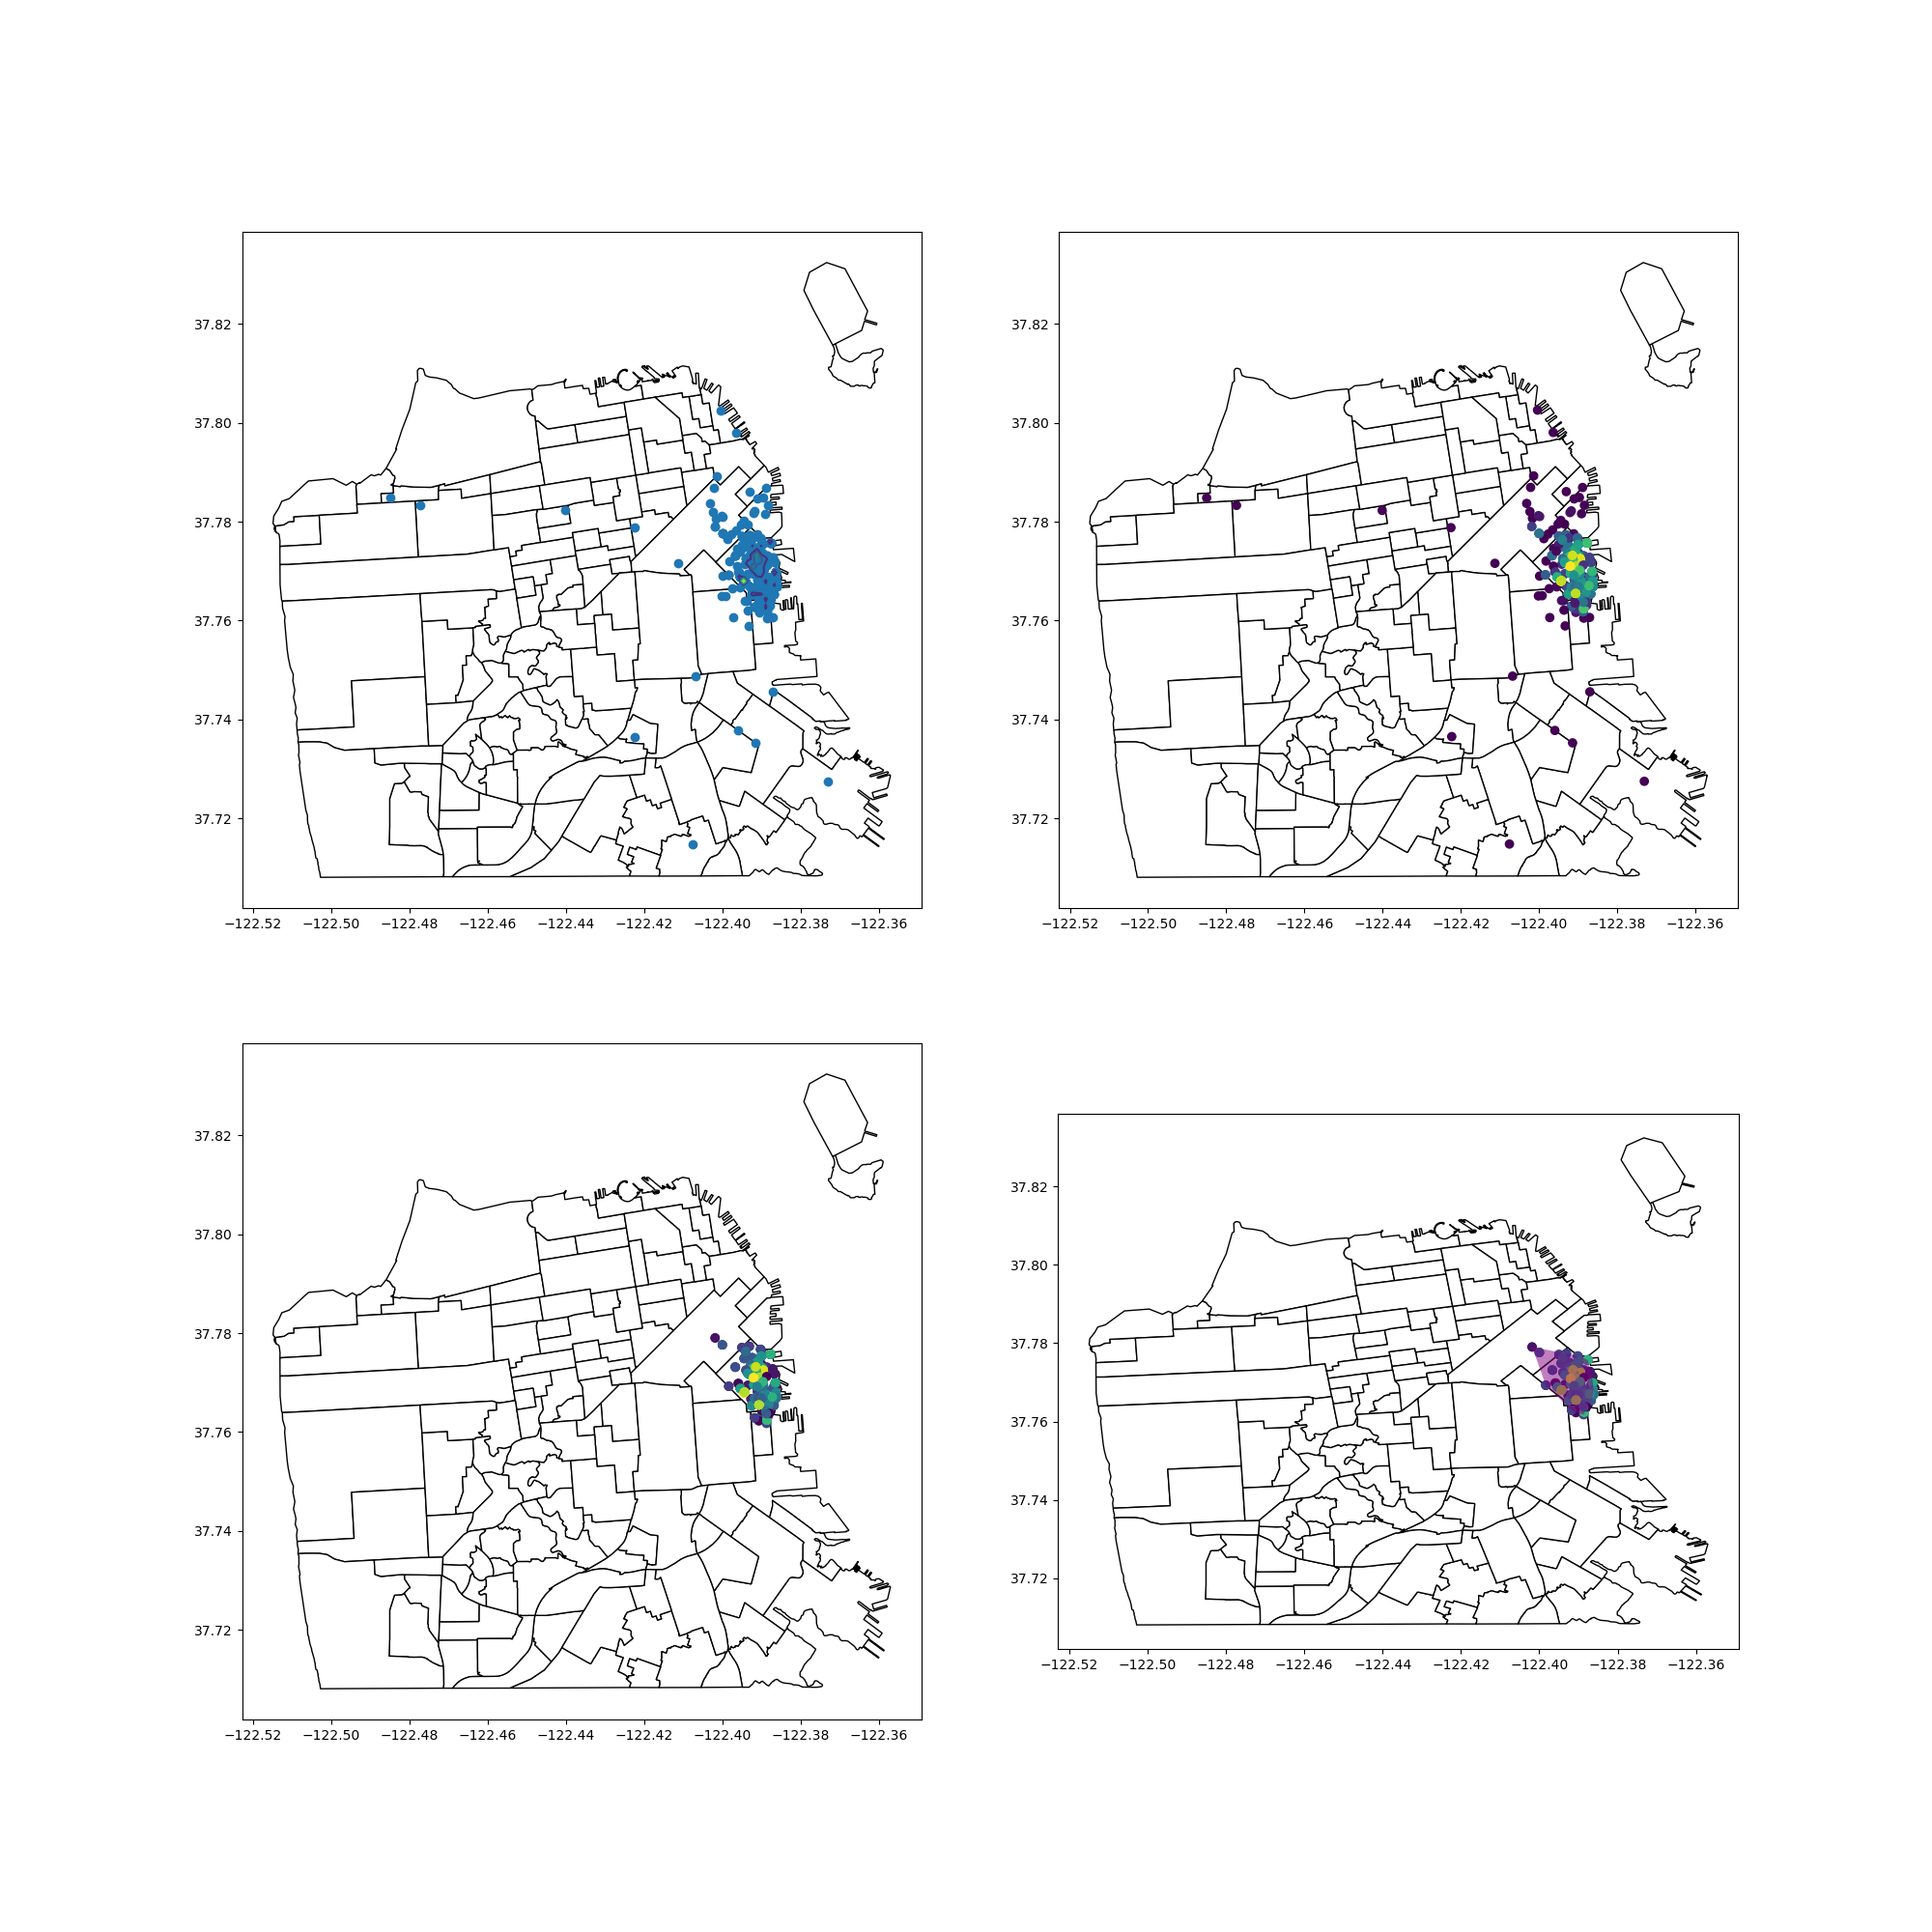

In [14]:
from IPython.display import Image, display
display(Image(filename='kde_imgs/filter-ENGINE - E04.png'))

### Store the results of the kernel density estimate as a flat file

* This data is loaded into the SQLite database using the script in that directory

In [15]:
catchment_areas = geo_pd.GeoDataFrame({
    "unit_desc": pd.Series(unit_ids),
    "bounding_box" : geo_pd.GeoSeries(bounding_boxes)}, geometry="bounding_box")
    
catchment_areas.to_csv(data_dir_prefix+'raw/catchments.csv')

### #3 Calculate Demand Grid (incident frequency in each zone)

### Figure out most common types of incidents that FIRE and ENGINE units respond to

In [16]:
freq = unit_response_data.groupby(["unit_type", "call_type"]).agg({"incident_number" : "count"})\
        .sort_values(["unit_type", "incident_number"], ascending=False)
top_three_calls = freq.groupby(['unit_type']).cumcount()
freq = freq.loc[top_three_calls < 5]
freq


incident_number
unit_type call_type                                       
TRUCK     Alarms                                     12616
          Structure Fire                              4867
          Medical Incident                            4304
          Citizen Assist / Service Call               2111
          Other                                       1108
...                                                    ...
CHIEF     Structure Fire                              2845
          Medical Incident                            1708
          Gas Leak (Natural and LP Gases)              620
          Traffic Collision                            500
AIRPORT   Other                                         52

[46 rows x 1 columns]

Show the zones that have the highest number of incidents (lighter colors)

C:\Users\ande7\anaconda3\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


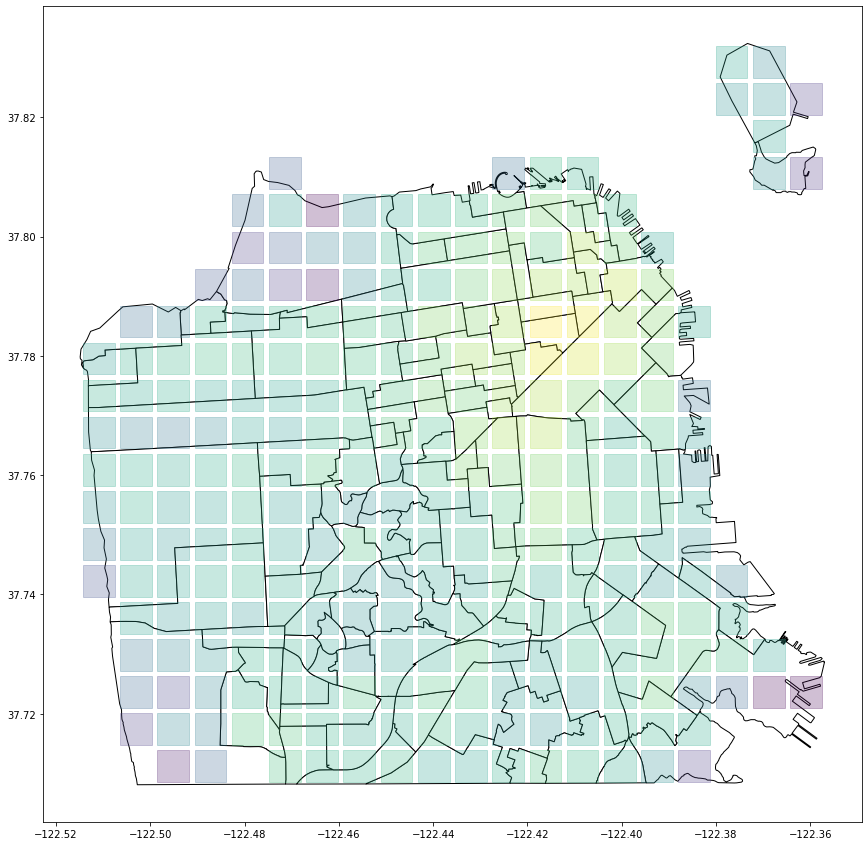

In [17]:
%matplotlib inline

incident_filter = pd.concat([freq.loc["TRUCK"].reset_index(), freq.loc["ENGINE"].reset_index()]).drop("incident_number", axis=1).drop_duplicates().reset_index(drop=True)

demand_data = unit_response_data.loc[unit_response_data.unit_type.eq("ENGINE") | unit_response_data.unit_type.eq("TRUCK")]
demand_data = demand_data.merge(incident_filter, how="inner", on="call_type")
demand_data = geo_pd.sjoin(demand_data, grid_zones, how="inner", op="within")

average_demand = demand_data.groupby('zone_idx').agg({"incident_number":"count"})
average_demand.rename({"incident_number":"incident_count"}, inplace=True, axis=1)
average_demand = grid_zones.merge(average_demand, on="zone_idx")

plt.rcParams["figure.figsize"]=15,15
full_plot = sf_neighborhoods.plot(color="white", edgecolor="black")
_ = average_demand.centroid.plot(markersize=1000, marker="s", c = np.log(average_demand.incident_count.to_numpy()), ax=full_plot, alpha=0.25)


### Merge each of the individual unit's response areas into a single response area for each fire station 

* Each point on the map below corresponds to a polygon of the same color, which shows the (often overlapping) regions that each fire station can service in under 5 minutes

Skipping 51...
	# truck areas: 0
	# engine areas: 1
	# station: 0


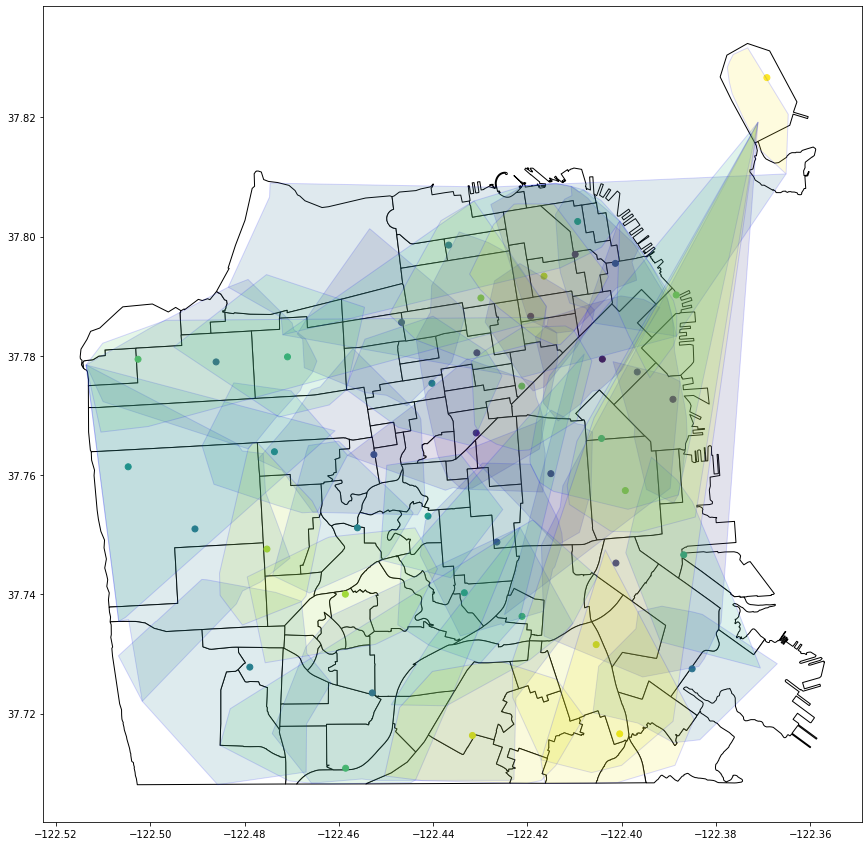

In [18]:
from shapely.ops import unary_union

unit_catchment_data = catchment_areas.unit_desc.str.split(" - ", expand=True).rename(columns={0:"unit_type", 1:"unit_code"})
fire_stations_name_col = unit_catchment_data.unit_code.str.extract("(\d+$)").rename(columns={0:"fire_station_number"})
unit_catchment_data = pd.concat([catchment_areas, unit_catchment_data, fire_stations_name_col], axis=1)
unit_catchment_data['fire_station_number'] = unit_catchment_data['fire_station_number'].astype('int64') 

truck_catchment_data = unit_catchment_data.loc[unit_catchment_data.unit_type.eq("TRUCK")]
engine_catchment_data = unit_catchment_data.loc[unit_catchment_data.unit_type.eq("ENGINE")]
fire_station_list = list(unit_catchment_data.fire_station_number.unique())

catchment_fire_station_name = []
catchment_fire_station_number = []
catchment_fire_station_areas = []
catchment_fire_station_location = []

fire_stations["fire_station_number"] = fire_stations.common_name.str.extract("#(\d+)")
fire_stations["fire_station_number"] = fire_stations["fire_station_number"].astype('int64')

# for each fire station, populate the zones that it can respond to in under 5 minutes
for station in fire_station_list:
    truck_area = truck_catchment_data.loc[truck_catchment_data.fire_station_number.eq(station)]
    engine_area = engine_catchment_data.loc[engine_catchment_data.fire_station_number.eq(station)]
    curr_fire_station = fire_stations.loc[fire_stations.fire_station_number.eq(station)]
        
    if (truck_area.shape[0] == 1 or engine_area.shape[0] == 1) and (curr_fire_station.shape[0] == 1 or station == 7):
        catchment_fire_station_name.append(curr_fire_station.common_name.values[0])
        catchment_fire_station_number.append(station)

        if truck_area.shape[0] == 1:
            truck_area = truck_area.bounding_box.values[0]
        else:
            truck_area = engine_area.bounding_box.values[0]

        if engine_area.shape[0] == 1:
            engine_area = engine_area.bounding_box.values[0]
        else:
            engine_area = truck_area.bounding_box.values[0]

        catchment_fire_station_areas.append(unary_union([truck_area, engine_area]))
        catchment_fire_station_location.append(curr_fire_station.iloc[0].point)
    else:        
        print(f"Skipping {station}...")        
        print(f"\t# truck areas: {truck_area.shape[0]}")
        print(f"\t# engine areas: {engine_area.shape[0]}")
        print(f"\t# station: {curr_fire_station.shape[0]}")

final_catchments = geo_pd.GeoDataFrame({
    "common_name": catchment_fire_station_name,
    "fire_station_number":catchment_fire_station_number,
    "station_location": geo_pd.GeoSeries(catchment_fire_station_location, crs="EPSG:4326"),
    "catchment_area": geo_pd.GeoSeries(catchment_fire_station_areas, crs="EPSG:4326")
}, geometry="catchment_area", crs="EPSG:4326")

full_plot = sf_neighborhoods.plot(color="white", edgecolor="black")
_ = final_catchments.station_location.plot(cmap = "viridis", ax=full_plot)
_ = final_catchments.catchment_area.plot(cmap = "viridis", alpha=0.15, edgecolor="blue", ax=full_plot)

In [34]:
final_catchments.loc[:, ['common_name', 'fire_station_number', 'catchment_area']].to_file(vis_dir_prefix+"/data/catchment_areas.geojson", driver="GeoJSON")

### #4 Calculate Spatial Accessibility

* Using the incidents and area that each fire station can respond to, calculate spatial accessibility for each zone. This is the number of fire units (trucks/engines) divided by the number of annual incidents at each point on the map, depending on the decay function used.  
* Since there is significant overlap in the areas serviced by each fire station, this helps to understand **where there are proportionally fewer fire units available** when adjusted for the total number of incidents requiring a response.

In [19]:
# build a pivoted dataframe to use as a distance matrix
catchment_zones = geo_pd.sjoin(final_catchments, average_demand, how="inner", op="intersects")
catchment_zones = catchment_zones.loc[:, ['fire_station_number', 'zone_idx', 'incident_count']]
catchment_zones.set_index("zone_idx", inplace=True)
catchment_zones['dummy'] = 1
catchment_zones = catchment_zones.pivot(columns="fire_station_number", values='dummy')
catchment_zones.fillna(999, inplace=True)
catchment_zones.to_csv(data_dir_prefix + "/catchment_zone_dist.csv")

# lookup demand values for each row
demand_lookup = average_demand.set_index("zone_idx")
demand_values = []
for zone_idx in catchment_zones.index:
    demand_values.append(demand_lookup.loc[zone_idx].incident_count)

demand_values = np.array(demand_values)

# supply is just 1 per station
supply_values = np.ones(len(catchment_zones.columns))


C:\Users\ande7\anaconda3\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


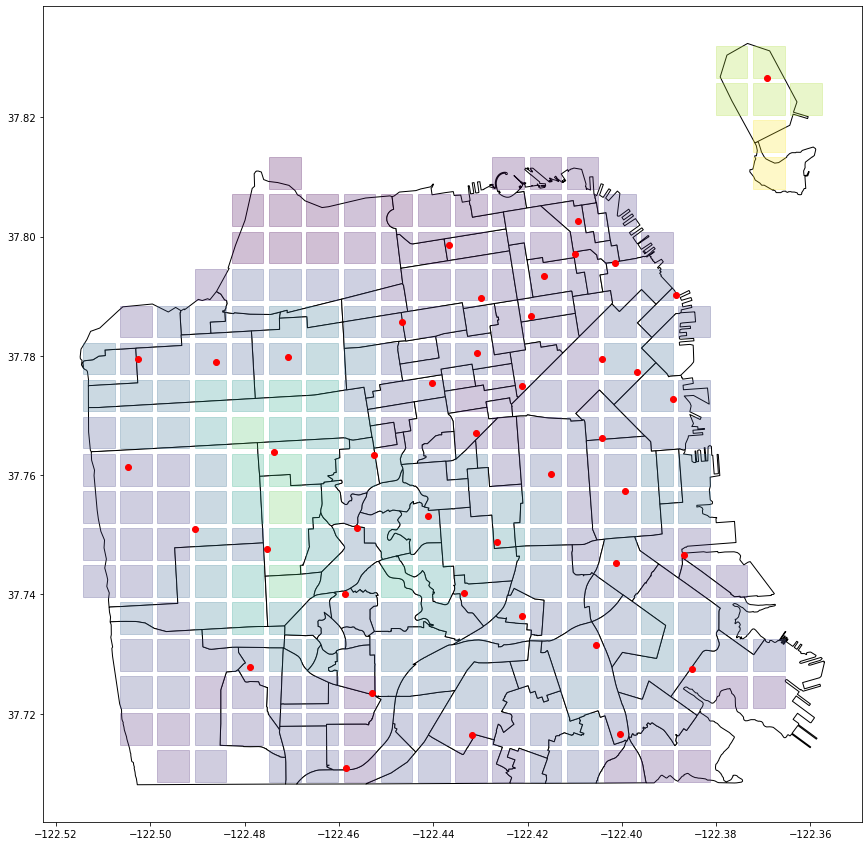

In [20]:
from aceso.gravity import TwoStepFCA

fca = TwoStepFCA(1.5)
fca_output = fca.calculate_accessibility_scores(catchment_zones.to_numpy(), demand_values, supply_values)

fca_output_df = pd.DataFrame({
    "zone_idx": pd.Series(catchment_zones.index),
    "accessibility_score": pd.Series(fca_output)
})
fca_output_df['scenario_name'] = 'baseline'
fca_output_df.to_csv(data_dir_prefix+'/raw/baseline_fca_output.csv')

zone_output_df = average_demand.merge(fca_output_df, on="zone_idx", how="inner")

full_plot = sf_neighborhoods.plot(color="white", edgecolor="black")
_ = zone_output_df.centroid.plot(
    markersize=1000, 
    marker="s", 
    c = zone_output_df.accessibility_score.to_numpy(),
    ax=full_plot, 
    alpha=0.25)

_= final_catchments.station_location.plot(color="red", ax=full_plot)

In [21]:
fca_output_df.to_csv(vis_dir_prefix+"/data/baseline_fca_output.csv")
fca_output_df

,zone_idx,accessibility_score,scenario_name
0,8,0.000512,baseline
1,9,0.000512,baseline
2,10,0.000340,baseline
3,11,0.000292,baseline
4,12,0.000292,baseline
...,...,...,...
260,362,0.001477,baseline
261,363,0.001493,baseline
262,376,0.000332,baseline
263,377,0.000156,baseline


###  #5 Simulate New Fire Stations

Using data queried from the BingMaps API, create a new catchment (hypothetical fire station) by estimating the five minute response area for each zone on the map.  

In [22]:
# load travel times

with sqlite3.connect(database_path) as db_conn:
    
    travel_times = pd.read_sql_query("select * from zone_distance", db_conn)
    travel_times['zone_from'] = geo_pd.GeoSeries(travel_times['zone_from'].apply(shapely.wkt.loads), crs="EPSG:4326")
    travel_times['zone_to'] = geo_pd.GeoSeries(travel_times['zone_to'].apply(shapely.wkt.loads), crs="EPSG:4326")
    travel_times = geo_pd.GeoDataFrame(travel_times, geometry="zone_from", crs="EPSG:4326")


travel_times.head(10)

,index,zone_from_idx,zone_from,zone_to_idx,zone_to,travel_distance_km,travel_time_notraffic_seconds,travel_time_traffic_seconds
0,0,83,POINT (-122.47758 37.81089),275,POINT (-122.40827 37.73594),14.162,1325,1508
1,1,279,POINT (-122.40809 37.71110),275,POINT (-122.40827 37.73594),3.913,314,373
2,2,339,POINT (-122.38071 37.71245),275,POINT (-122.40827 37.73594),5.827,386,426
3,3,73,POINT (-122.48686 37.74852),275,POINT (-122.40827 37.73594),12.453,995,992
4,4,235,POINT (-122.42410 37.73603),275,POINT (-122.40827 37.73594),1.527,292,293
5,5,145,POINT (-122.45573 37.79807),275,POINT (-122.40827 37.73594),11.824,1190,1257
6,6,177,POINT (-122.44785 37.72366),275,POINT (-122.40827 37.73594),4.625,323,377
7,7,32,POINT (-122.50307 37.75494),275,POINT (-122.40827 37.73594),14.483,1126,1178
8,8,376,POINT (-122.36880 37.72989),275,POINT (-122.40827 37.73594),4.749,697,704
9,9,68,POINT (-122.48723 37.77963),275,POINT (-122.40827 37.73594),12.954,1278,1368


In [23]:
# build out a data structure of response times (new catchments) for the simulation

zone_list = travel_times.zone_from_idx.unique()
max_travel_time = 6 * 60 # 5 and a half minutes, converted to seconds

# initial filtering
travel_times = travel_times.loc[travel_times.travel_time_notraffic_seconds <= max_travel_time]

simulation_zone = []
simulation_zone_area = []
simulation_zone_pt = []

for z in zone_list:
    zone_travel_times = travel_times.loc[travel_times.zone_from_idx == z]
    zone_to_points = zone_travel_times.zone_to
    zone_from_points = zone_travel_times.zone_from.drop_duplicates()
    zone_points = list(zone_to_points)
    if len(zone_from_points) == 0: continue
    zone_points.append(list(zone_from_points)[0])
    simulation_zone.append(z)
    simulation_zone_pt.append(list(zone_from_points)[0])
    simulation_zone_area.append(MultiPoint(zone_points).convex_hull)

simulation_area_df = geo_pd.GeoDataFrame({
    "zone_idx": pd.Series(simulation_zone),
    "zone_pt" : geo_pd.GeoSeries(simulation_zone_pt, crs="EPSG:4326"),
    "zone_area": geo_pd.GeoSeries(simulation_zone_area, crs="EPSG:4326")
}, geometry="zone_area", crs="EPSG:4326")

simulation_area_df

,zone_idx,zone_pt,zone_area
0,83,POINT (-122.47758 37.81089),"POLYGON ((-122.47170 37.77955, -122.47935 37.7..."
1,279,POINT (-122.40809 37.71110),"POLYGON ((-122.42404 37.71028, -122.42416 37.7..."
2,339,POINT (-122.38071 37.71245),"POLYGON ((-122.40020 37.71112, -122.40043 37.7..."
3,73,POINT (-122.48686 37.74852),"POLYGON ((-122.49563 37.73603, -122.49524 37.7..."
4,235,POINT (-122.42410 37.73603),"POLYGON ((-122.46350 37.71120, -122.43972 37.7..."
...,...,...,...
277,131,POINT (-122.46394 37.76089),"POLYGON ((-122.46364 37.74213, -122.47128 37.7..."
278,70,POINT (-122.48671 37.76658),"POLYGON ((-122.49495 37.74850, -122.50274 37.7..."
279,291,POINT (-122.40029 37.76094),"POLYGON ((-122.40827 37.73594, -122.40839 37.7..."
280,275,POINT (-122.40827 37.73594),"POLYGON ((-122.40809 37.71110, -122.46350 37.7..."


#### Run the simulation for each zone on the map

In [50]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

all_simulation_outputs = []
travel_times_df = []

for sim_idx in range(1, simulation_area_df.shape[0]):

    curr_sim = simulation_area_df.iloc[[sim_idx]]
    sim_area = geo_pd.sjoin(grid_zones, curr_sim, how="inner", op="intersects")

    travel_times_df.append(
        sim_area.loc[:, ['zone_idx_right', 'zone_idx_left']]\
            .rename({
                "zone_idx_right":"selected_zone", 
                "zone_idx_left":"covered_zone"}, axis=1) 
    )

    sim_df = final_catchments.copy()
    sim_df = sim_df.append({
        "common_name" : "New Firestation",
        "fire_station_number": 999,
        "station_location" : list(curr_sim.zone_pt)[0],
        "catchment_area" : list(curr_sim.zone_area)[0]
    },ignore_index=True)
    sim_df = geo_pd.GeoDataFrame(sim_df, geometry='catchment_area', crs='EPSG:4326')

    new_catchment_zones = geo_pd.sjoin(sim_df, average_demand, how="inner", op="intersects")
    new_catchment_zones = new_catchment_zones.loc[:, ['fire_station_number', 'zone_idx', 'incident_count']]
    new_catchment_zones.set_index("zone_idx", inplace=True)
    new_catchment_zones['dummy'] = 1
    new_catchment_zones = new_catchment_zones.pivot(columns="fire_station_number", values='dummy')
    new_catchment_zones.fillna(999, inplace=True)

    # lookup demand values for each row
    demand_lookup = average_demand.set_index("zone_idx")
    demand_values = []
    for zone_idx in new_catchment_zones.index:
        demand_values.append(demand_lookup.loc[zone_idx].incident_count)

    demand_values = np.array(demand_values)

    # # supply is just 1 per station
    supply_values = np.ones(len(new_catchment_zones.columns))
    supply_values[len(new_catchment_zones.columns) - 1] = 2

    #full_plot = sf_neighborhoods.plot(color="white", edgecolor="black")
    #_ = sim_area.plot(ax=full_plot)

    sim_fca = TwoStepFCA(1.5)
    sim_fca_output = sim_fca.calculate_accessibility_scores(new_catchment_zones.to_numpy(), demand_values, supply_values)

    sim_fca_output_df = pd.DataFrame({
        "zone_idx": pd.Series(new_catchment_zones.index),
        "accessibility_score": pd.Series(sim_fca_output)
    })
    sim_fca_output_df['scenario_name'] = 'new_station_' + str(int(curr_sim.zone_idx))
    sim_zone_output_df = average_demand.merge(sim_fca_output_df, on="zone_idx", how="inner")
    all_simulation_outputs.append(sim_zone_output_df)

all_simulation_outputs = pd.concat(all_simulation_outputs, ignore_index=True)


In [51]:
all_simulation_outputs

,zone_idx,zone,incident_count,accessibility_score,scenario_name
0,8,"POLYGON ((-122.51490 37.78267, -122.51490 37.7...",139,0.000512,new_station_279
1,27,"POLYGON ((-122.50700 37.78889, -122.50700 37.7...",32,0.000220,new_station_279
2,28,"POLYGON ((-122.50700 37.78267, -122.50700 37.7...",279,0.000364,new_station_279
3,47,"POLYGON ((-122.49911 37.78889, -122.49911 37.7...",58,0.000397,new_station_279
4,48,"POLYGON ((-122.49911 37.78267, -122.49911 37.7...",329,0.000397,new_station_279
...,...,...,...,...,...
74469,360,"POLYGON ((-122.37277 37.83240, -122.37277 37.8...",76,0.001305,new_station_225
74470,361,"POLYGON ((-122.37277 37.82618, -122.37277 37.8...",107,0.001305,new_station_225
74471,362,"POLYGON ((-122.37277 37.81997, -122.37277 37.8...",177,0.001477,new_station_225
74472,381,"POLYGON ((-122.36488 37.82618, -122.36488 37.8...",7,0.001305,new_station_225


In [52]:
catchment_zones = geo_pd.sjoin(final_catchments, average_demand, how="inner", op="intersects")
catchment_zones = catchment_zones.loc[:, ['fire_station_number', 'zone_idx', 'incident_count']]
catchment_zones.set_index("zone_idx", inplace=True)
catchment_zones['dummy'] = 1
catchment_zones = catchment_zones.pivot(columns="fire_station_number", values='dummy')
catchment_zones.fillna(999, inplace=True)
catchment_zones.to_csv(data_dir_prefix + "/catchment_zone_dist.csv")

# lookup demand values for each row
demand_lookup = average_demand.set_index("zone_idx")
demand_values = []
for zone_idx in catchment_zones.index:
    demand_values.append(demand_lookup.loc[zone_idx].incident_count)

demand_values = np.array(demand_values)

# supply is just 1 per station
supply_values = np.ones(len(catchment_zones.columns))

In [53]:
# output the simulation results
all_simulation_outputs.to_csv(data_dir_prefix+"/raw/simulation_fca_output.csv")
all_simulation_outputs.drop("zone", axis=1).to_csv(vis_dir_prefix+"/data/simulation_fca_output.csv")

# output the traveljtimes
pd.concat(travel_times_df, ignore_index=True, axis=0).to_csv(vis_dir_prefix+"data/travel_time.csv")